In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# explore the data

import argparse
import os
import json
from typing import List, Tuple
from loguru import logger
from ehrshot.utils import LABELING_FUNCTION_2_PAPER_NAME
import pandas as pd
from tqdm import tqdm
from femr.datasets import PatientDatabase
import femr
from datetime import datetime
from collections import defaultdict

In [2]:
# one line of code to configure the patient database
def configure_database(path_to_database: str) -> PatientDatabase:
    return PatientDatabase(path_to_database)

In [3]:
def inspect_object(obj):
    all_attributes = dir(obj)
    methods = []
    values = []

    for attribute in all_attributes:
        # Check if the attribute is callable (method)
        if callable(getattr(obj, attribute)):
            methods.append(attribute)
        else:
            values.append(attribute)

    return methods, values

In [4]:
df_patient_los = pd.read_csv("EHRSHOT_ASSETS/benchmark/guo_los/labeled_patients.csv")
df_patient_ice = pd.read_csv("EHRSHOT_ASSETS/benchmark/guo_icu/labeled_patients.csv")
df_patient_re_admission = pd.read_csv("EHRSHOT_ASSETS/benchmark/guo_readmission/labeled_patients.csv")


df_patient = df_patient_los

database = configure_database("EHRSHOT_ASSETS/femr/extract")

with open('ehrshot_code_description.json', 'r') as f:
    code_description = json.load(f)

df_patient.loc[0]

patient_id                   115973157
prediction_time    2022-12-09 23:59:00
value                            False
label_type                     boolean
Name: 0, dtype: object

In [5]:
df_patient = df_patient_los
patient_id = df_patient.loc[0].patient_id
prediction_time = df_patient.loc[0].prediction_time
prediction_label = df_patient.loc[0].value
prediction_time_datatime_format = datetime.fromisoformat(prediction_time)

In [6]:
array1 = df_patient_los['patient_id'].values
array2 = df_patient_ice['patient_id'].values
array3 = df_patient_re_admission['patient_id'].values
intersect12 = np.intersect1d(array1, array2)
final_intersect = np.intersect1d(intersect12, array3)

In [7]:
intersection_df = pd.merge(df_patient_los, df_patient_ice, on=['prediction_time', 'patient_id'], how='inner')

In [8]:
delta_list = []
id_list = []
admission_date_list = []
discharge_date_list = []
for i in range(len(intersection_df)):
    temp_patient_id = intersection_df.loc[i].patient_id
    temp_prediction_time = intersection_df.loc[i].prediction_time
    if temp_patient_id in df_patient_re_admission['patient_id'].values:
        re_admission_time = df_patient_re_admission[df_patient_re_admission['patient_id'] == temp_patient_id].prediction_time.values[0]
        assert len(re_admission_time) == 19
        # patient_femr_object = database[temp_p atient_id]
        delta = datetime.fromisoformat(re_admission_time) - datetime.fromisoformat(temp_prediction_time)
        if delta.days > 0 and delta.days < 30:
            delta_list.append(delta.days)
            id_list.append(temp_patient_id)
            admission_date_list.append(temp_prediction_time)
            discharge_date_list.append(re_admission_time)
        elif delta.days > 80:
            print(delta.days)

154
133
127
87


In [9]:
df_common = pd.DataFrame([id_list, admission_date_list, discharge_date_list, delta_list]).T
df_common = df_common.rename(columns={0: 'patient_id', 1: 'admission_date', 2: 'discharge_date', 3: 'delta_days'})
df_common.to_csv('common_patients.csv', index=False)

In [10]:
def describe_events(events, code_description):
    # Organize events by code
    grouped_events = {}
    for event in events:
        if event.code in grouped_events:
            grouped_events[event.code].append(event)
        else:
            grouped_events[event.code] = [event]

    # Mock database dictionary to translate medical codes

    descriptions = []
    for code, group in grouped_events.items():
        # Start the description for this group
        event_type = code_description.get(code, code)
        times = ', '.join(set(e.start.strftime('%B %d, %Y, %H:%M') for e in group))
        # description = f"On {times}, {len(group)} events categorized under the code '{code}' ({event_type}) occurred."

        # description = f"On {times}, {len(group)} {group[0].omop_table} medical events ({event_type}) occurred."
        description = f"{len(group)} {group[0].omop_table} medical events ({event_type}) occurred."
        # Check if any event in the group has a value
        values = set(e.value for e in group if e.value is not None)
        if values:
            description += f" The values recorded were: {', '.join(map(str, values))}."

        # description += f" These events were recorded in the '{group[0].omop_table}' table."
        
        descriptions.append(description)
    
    # Combine all descriptions into a single paragraph
    return ' \n'.join(descriptions)

def add_patient_age(prediction_time_datatime_forma, database, patient_id, text, task = 'admission'):
    time_lap = prediction_time_datatime_format.date() - database.get_patient_birth_date(patient_id)
    patient_age = time_lap.days // 365
    date = prediction_time_datatime_format.date().strftime('%B %d, %Y')
    return f"The patient was {patient_age} years old.\nIn {date}, at the time of the {task}:\n" + text

In [11]:
description_list = []
for i in tqdm(range(len(df_common))):
    patient_id = df_common.loc[i].patient_id
    prediction_time = df_common.loc[i].admission_date
    discharge_time = df_common.loc[i].discharge_date
    discharge_time = datetime.fromisoformat(discharge_time)
    prediction_time = datetime.fromisoformat(prediction_time)
    patient_femr_object = database[patient_id]
    assert patient_id == patient_femr_object.patient_id
    patient_events = patient_femr_object.events

    event_start_time = []
    all_event = []

    for e in patient_events:
        elif (discharge_time - time_start).days > 0 and time_start > prediction_time:
            all_event.append(e)
    description = describe_events(all_event, code_description)
    description = add_patient_age(prediction_time, database, patient_id, description)
    description_list.append(description)

100%|██████████| 3268/3268 [01:07<00:00, 48.53it/s]


In [12]:
df_common['description'] = description_list
df_common.to_csv('common_patients_description.csv', index=False)

In [13]:
import re
_re_word_boundaries = re.compile(r'\b')

def num_words(line):
    return len(_re_word_boundaries.findall(line)) >> 1

In [14]:
import pandas as pd
import nltk
df = pd.read_csv("common_patients_description.csv")
token_list = []
for i in range(len(df)):
    words = df['description'][i]
    token_list.append(num_words(words))
# nltk.word_tokenize(df['description'][0])

In [35]:
for i in final_intersect:
    temp_df_1 = intersection_df[intersection_df['patient_id'] == i]
    temp_df_2 = df_patient_re_admission[df_patient_re_admission['patient_id'] == i]

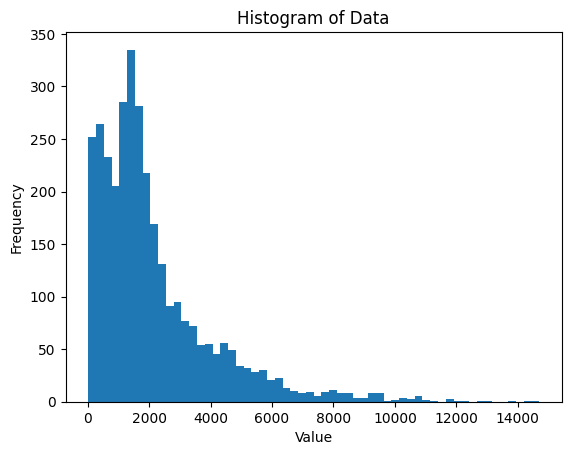

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example array of data
data = token_list

# Plotting the histogram
plt.hist(data, bins='auto')  # 'auto' lets matplotlib decide the number of bins
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [37]:
temp_df_2

,patient_id,prediction_time,value,label_type
214,121124990,2018-03-23 23:59:00,False,boolean


In [13]:
patient_femr_object = database[patient_id]
assert patient_id == patient_femr_object.patient_id
patient_events = patient_femr_object.events

event_start_time = []
all_event = []

for e in patient_events:
    time_start = e.start
    if time_start == prediction_time_datatime_format:
        event_start_time.append(time_start)
        all_event.append(e)
        print(e)

Event(start=2022-12-09 23:59:00, code=Visit/IP, value=None, =474, end=2022-12-09 23:59:00, visit_id=214453889.0, omop_table=visit_occurrence)
Event(start=2022-12-09 23:59:00, code=SNOMED/34139004, value=None, =112951, end=2022-12-09 23:59:00, omop_table=condition_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/00670, value=None, =3737, visit_id=214436067.0, omop_table=procedure_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/36415, value=None, =5193, visit_id=214427186.0, omop_table=procedure_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/36620, value=None, =5791, visit_id=214436067.0, omop_table=procedure_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/86850, value=None, =12969, visit_id=214427186.0, omop_table=procedure_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/86900, value=None, =13325, visit_id=214427186.0, omop_table=procedure_occurrence)
Event(start=2022-12-09 23:59:00, code=CPT4/86901, value=None, =13469, visit_id=214427186.0, omop_table